In [122]:
from collections import Counter, deque
import random
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from fractions import Fraction
import numpy as np
import scipy as sp
import scipy.linalg as la

In [183]:

board = """GO   R1 Car R2  R3 R4 R5  DiagonAlley R7 ZombieVines
           Swamp R8 R9  R10  R11 R12 Car  GarlicGarden R13 R14 
           DiagonAlley   R16 R17 R18  Swamp R19 R20  ZombieVines  R21 Car 
           R22  R23 DiagonAlley  R25 R26 R27 R28 Swamp  GarlicGarden R29""".split()
board

['GO',
 'R1',
 'Car',
 'R2',
 'R3',
 'R4',
 'R5',
 'DiagonAlley',
 'R7',
 'ZombieVines',
 'Swamp',
 'R8',
 'R9',
 'R10',
 'R11',
 'R12',
 'Car',
 'GarlicGarden',
 'R13',
 'R14',
 'DiagonAlley',
 'R16',
 'R17',
 'R18',
 'Swamp',
 'R19',
 'R20',
 'ZombieVines',
 'R21',
 'Car',
 'R22',
 'R23',
 'DiagonAlley',
 'R25',
 'R26',
 'R27',
 'R28',
 'Swamp',
 'GarlicGarden',
 'R29']

In [184]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [185]:
cars_i = list_duplicates_of(board,'Car')
cars_i
board[31]

'R23'

In [186]:

def IOB(steps):
    """Simulate given number of steps of Monopoly game, 
    yielding the number of the current square after each step."""
    goto(0) # start at GO
    cars_i = list_duplicates_of(board,'Car')
    
    for _ in range(steps):
        die = random.randint(1, 6) # roll die
        if isinstance(die, int):
            goto(here + die)  # here is a global variable, so gets initialized to 0. It's modulo-40
        else:
            goto(here)
        if (board[here] == 'Car'):
            goto(here + 2)
        elif (board[here] == 'Swamp'):
            goto(here)
        yield here  # yield ensures IOB() returns a *list* of positions. Also, allows to resume where we left off       

def goto(cell):
    "Update the global variable 'here' to be certain cell."
    global here
    here = cell % len(board)

In [187]:
results = list(IOB(400000))

In [188]:

pd.DataFrame(results[0:100]).T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3,9,13,19,21,24,30,32,36,4,...,9,12,13,14,15,18,21,25,28,32


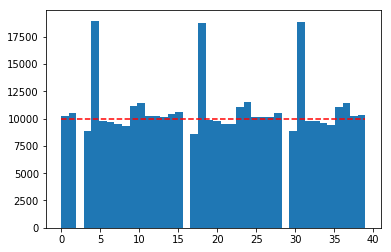

In [189]:

plt.hist(results, bins=40)
avg = len(results) / 40
plt.plot([0, 39], [avg, avg], 'r--');

In [190]:
board[4]

'R3'

In [191]:

def P(pred, dst): 
    "Proba that pred is true, given the dst pdf"
    return sum(dst[e] for e in dst if pred(e))

class ProbabilityDistribution(dict):
    "A Probability Distribution; an {outcome: probability} mapping where probabilities sum to 1."
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        total = sum(self.values())
        if isinstance(total, int): 
            total = Fraction(total, 1)
        for key in self: # Make probabilities sum to 1.
            self[key] = self[key] / total
            
    def __and__(self, pred): # Call this method by writing ProbabilityDistribution & predicate
        "New ProbabilityDistribution, for outcomes of this ProbabilityDistribution for which pred is true."
        return ProbabilityDistribution({e:self[e] for e in self if pred(e)})

def Uniform(out): return ProbabilityDistribution({e: 1 for e in out})

def joint(X, Y, sep=''):
    "joint pdf of two independent pdfs. Entries of the shape {x+sep+y: P(x)*P(y)}"
    return ProbabilityDistribution({x + sep + y: X[x] * Y[y]
                    for x in X
                    for y in Y})

In [192]:
probD = ProbabilityDistribution(Counter(board[i] for i in results))
probD

{'R2': Fraction(2217, 100000),
 'ZombieVines': Fraction(21331, 400000),
 'R10': Fraction(10169, 400000),
 'R14': Fraction(989, 40000),
 'R16': Fraction(9533, 400000),
 'Swamp': Fraction(17169, 200000),
 'R22': Fraction(4409, 200000),
 'DiagonAlley': Fraction(14539, 200000),
 'R28': Fraction(11093, 400000),
 'R3': Fraction(18957, 400000),
 'R7': Fraction(9343, 400000),
 'R9': Fraction(5137, 200000),
 'R11': Fraction(5223, 200000),
 'R13': Fraction(939, 20000),
 'R17': Fraction(9491, 400000),
 'R20': Fraction(2029, 80000),
 'R21': Fraction(5251, 200000),
 'R26': Fraction(2387, 100000),
 'GO': Fraction(10227, 400000),
 'R8': Fraction(1021, 40000),
 'R27': Fraction(9423, 400000),
 'R29': Fraction(1287, 50000),
 'R12': Fraction(5321, 200000),
 'R18': Fraction(5517, 200000),
 'R19': Fraction(10159, 400000),
 'R23': Fraction(1179, 25000),
 'R5': Fraction(4833, 200000),
 'R4': Fraction(9779, 400000),
 'GarlicGarden': Fraction(18841, 400000),
 'R25': Fraction(9739, 400000),
 'R1': Fraction(2629

Probability of landing on each cell on the game board, notice that player has the most probability of landing on cell 13, 14 (Road 10 & 11) 

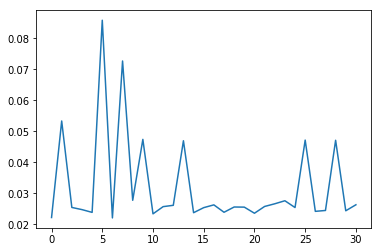

In [193]:
v = [];
for f in probD.values():
    v.append(float(f))
v
plt.plot(v)

Compute the regular transition matrix.

In [194]:
regular = np.zeros((40,40))

In [195]:
dieroll_distance = np.zeros(40)

In [196]:
rolls = [2, 1, 1, 1, 1]
for index, r in enumerate(rolls):
    dieroll_distance[index] = r
dieroll_distance /= 6
print(dieroll_distance)

[0.33333333 0.16666667 0.16666667 0.16666667 0.16666667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [197]:
for row in range(40):
    regular[row] = np.roll(dieroll_distance, row)
pd.DataFrame(regular)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Compute the special transition matrix that takes Car and Swamp cells into consideration


In [198]:
special = np.zeros((40,40))

In [205]:
swamps_i = list_duplicates_of(board,'Swamp')
diagonalleys_i = list_duplicates_of(board,'DiagonAlley')
for c in range(40):
    if c in cars_i:
        special[c,c+3] = 1.0
    elif c in swamps_i:
        special[c,c] = 1
    elif c in diagonalleys_i:
        special[c,c+1] = 1/2
        special[c,c] = 1/2
    else:
        special[c, c] = 1.0
pd.DataFrame(special)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
transition = regular @ special
pd.DataFrame(transition)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.333333,0.166667,0.0,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.333333,0.0,0.166667,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.166667,0.166667,0.500000,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.333333,0.166667,0.166667,0.166667,0.083333,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.333333,0.166667,0.166667,0.083333,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.166667,0.083333,0.250000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.083333,0.250000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [207]:
for i in range(40):
    print(np.sum(transition[i]))

1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0


In [208]:
w, v = la.eig(transition)

In [212]:
v

array([[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.10359668+0.j, -0.0017282 +0.j, -0.09247645+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.05049524+0.j, -0.01206354+0.j,  0.1494406 +0.j],
       [ 1.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.04602043+0.j, -0.20672447+0.j,  0.21233705+0.j],
       ...,
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.10362264+0.j, -0.04506818+0.j,  0.31940017+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.05054715+0.j,  0.0250717 +0.j, -0.0875339 +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.07163524+0.j,  0.00951672+0.j, -0.08608212+0.j]])

In [210]:
w2, v2 = la.eig(transition)
w2

array([0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 1.        +0.j        ,
       0.92405005+0.27725517j, 0.92405005-0.27725517j,
       0.72615653+0.46896933j, 0.72615653-0.46896933j,
       0.48033756+0.52880989j, 0.48033756-0.52880989j,
       0.26670566+0.46582709j, 0.26670566-0.46582709j,
       0.13737449+0.32984116j, 0.13737449-0.32984116j,
       0.1010537 +0.18796469j, 0.1010537 -0.18796469j,
       0.32735151+0.11504644j, 0.32735151-0.11504644j,
       0.26098497+0.14248803j, 0.26098497-0.14248803j,
       0.35607121+0.05120042j, 0.35607121-0.05120042j,
       0.18554501+0.11837991j, 0.18554501-0.11837991j,
       0.1141502 +0.07607977j, 0.1141502 -0.07607977j,
       0.13293198+0.05130043j, 0.13293198-0.05130043j,
       0.32615857+0.00979771j, 0.32615857-0.00979771j,
       0.14534688+0.00549574j, 0.14534688-0.00549574j,
       0.16666667+0.j        , 0.2664358 +0.0483954j ,
       0.2664358 -0.0483954j , 0.20712339+0.00929276j,
       0.2

Dominant eigenvector

In [213]:
v[0]

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , -1.58113883e-01+0.j        ,
        1.62138892e-02-0.15764873j,  1.62138892e-02+0.15764873j,
       -1.56405334e-01-0.03044961j, -1.56405334e-01+0.03044961j,
       -6.93831031e-02+0.1439574j , -6.93831031e-02-0.1439574j ,
        5.79851774e-04-0.1577264j ,  5.79851774e-04+0.1577264j ,
       -8.05907039e-02-0.12519606j, -8.05907039e-02+0.12519606j,
       -1.26305180e-01+0.02716807j, -1.26305180e-01-0.02716807j,
       -1.07645809e-01+0.11697275j, -1.07645809e-01-0.11697275j,
        9.36494762e-02+0.09386854j,  9.36494762e-02-0.09386854j,
        5.95916525e-02-0.16390996j,  5.95916525e-02+0.16390996j,
        5.59403640e-02-0.08223099j,  5.59403640e-02+0.08223099j,
       -5.78447895e-02+0.08070199j, -5.78447895e-02-0.08070199j,
       -4.34355702e-02+0.01345344j, -4.34355702e-02-0.01345344j,
       -1.64714281e-01-0.02697405j, -1.64714281e-01+0.02697405j,
        1.22096247e-02+0.